In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Train.csv')

# Display the first few rows to check for a column that might indicate holidays
print(df.head())


             date_time is_holiday  air_pollution_index  humidity  wind_speed  \
0  2012-10-02 09:00:00       None                  121        89           2   
1  2012-10-02 10:00:00       None                  178        67           3   
2  2012-10-02 11:00:00       None                  113        66           3   
3  2012-10-02 12:00:00       None                   20        66           3   
4  2012-10-02 13:00:00       None                  281        65           3   

   wind_direction  visibility_in_miles  dew_point  temperature  rain_p_h  \
0             329                    1          1       288.28       0.0   
1             330                    1          1       289.36       0.0   
2             329                    2          2       289.58       0.0   
3             329                    5          5       290.13       0.0   
4             329                    7          7       291.14       0.0   

   snow_p_h  clouds_all weather_type weather_description  traf

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Train.csv')

# Check unique values in the 'is_holiday' column
print(df['is_holiday'].unique())

# Convert any value that is not 'None' to 1 (indicating a holiday) and 'None' to 0
df['is_holiday'] = df['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Verify the conversion
print(df['is_holiday'].value_counts())


['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
0    33707
1       43
Name: is_holiday, dtype: int64


In [3]:
# Group by the 'is_holiday' column and calculate average traffic volume
average_traffic_by_holiday = df.groupby('is_holiday')['traffic_volume'].mean()
print(average_traffic_by_holiday)

is_holiday
0    3243.182395
1     838.116279
Name: traffic_volume, dtype: float64


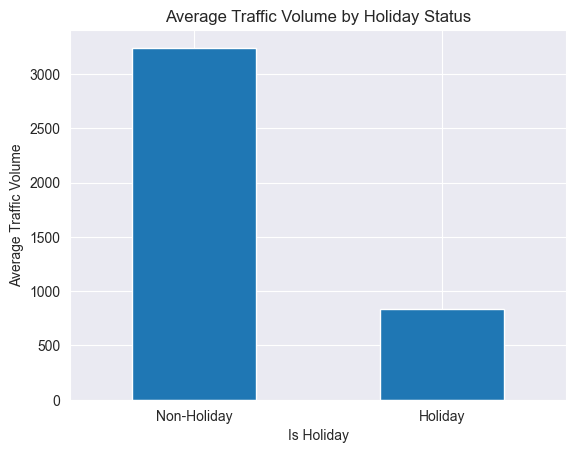

In [4]:
import matplotlib.pyplot as plt

# Plot average traffic volume by holiday status
average_traffic_by_holiday.plot(kind='bar')
plt.title('Average Traffic Volume by Holiday Status')
plt.xlabel('Is Holiday')
plt.ylabel('Average Traffic Volume')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

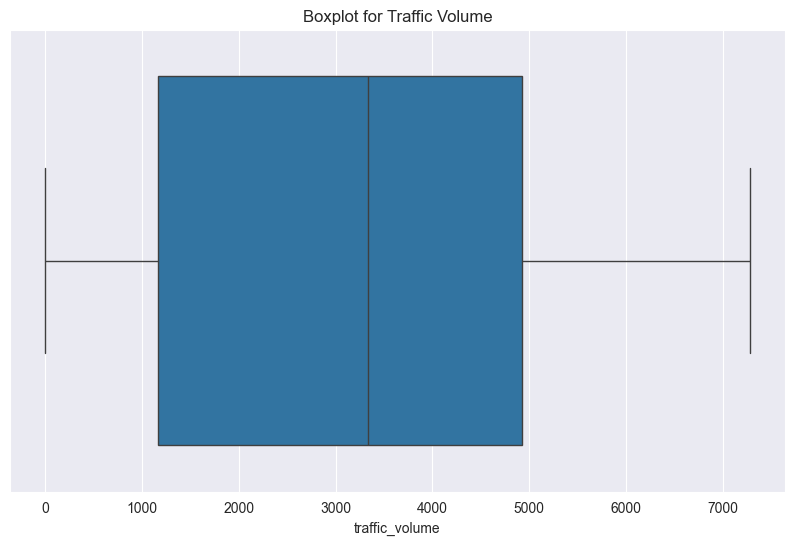

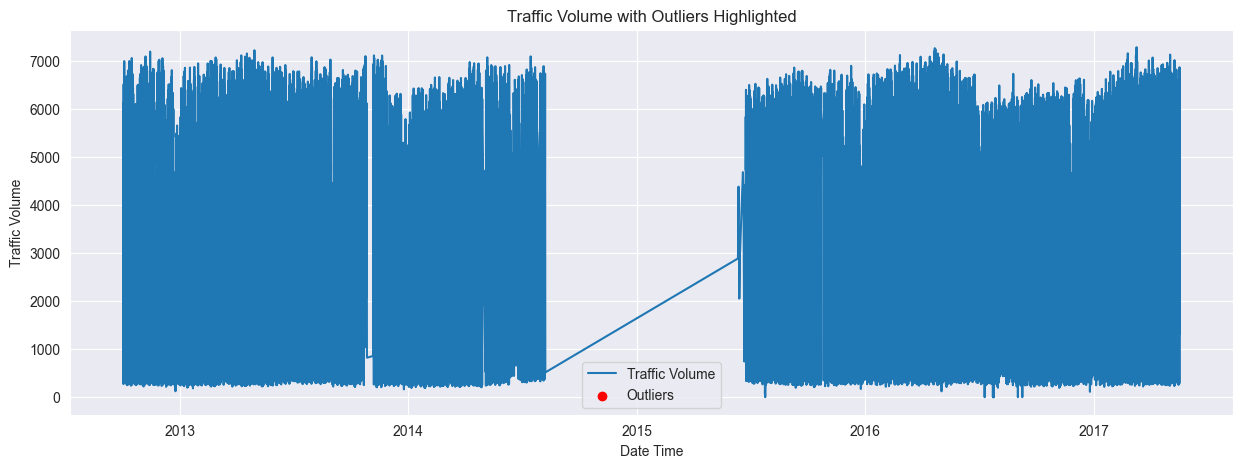

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_raw = pd.read_csv('Train.csv')
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Drop rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Calculate IQR for outlier detection
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
outliers = df[(df[target] < (Q1 - 1.5 * IQR)) | (df[target] > (Q3 + 1.5 * IQR))]

# Plot to visualize outliers using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[target])
plt.title('Boxplot for Traffic Volume')
plt.show()

# Plot a time series graph highlighting outliers
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[target], label='Traffic Volume')
plt.scatter(outliers.index, outliers[target], color='red', label='Outliers', zorder=5)
plt.title('Traffic Volume with Outliers Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


RandomizedSearchCV Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV Progress:   0%|          | 0/100 [12:29<?, ?it/s]


Best parameters found: {'subsample': 1.0, 'reg_alpha': 10, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}
MAPE scores for each fold: [12.875869011881463, 11.575388175304688, 12.001644933966897, 11.476031406673592, 358.3686595431535, 15.435763586830351, 11.418643300636328, 583.8566705759748, 11.675311389711537, 9.493484730082184]
Average MAPE across all folds: 103.81774666542154%
Root Mean Squared Error (RMSE): 305.52229373819677
Mean Absolute Error (MAE): 199.76114134388948
Normalized Root Mean Squared Error (RMSE): 0.04329350910276276
Normalized Mean Absolute Error (MAE): 0.028306807615685062
Mean Absolute Percentage Error (MAPE): 9.493484730082184%
R-squared (R2): 0.9772983301347031


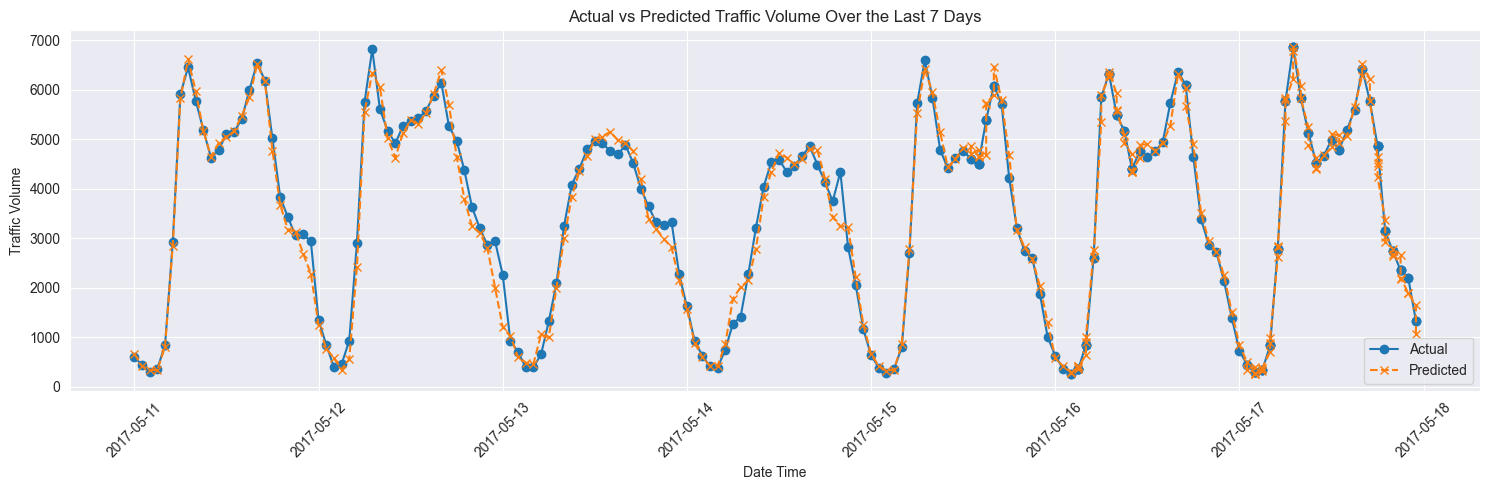

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

class TqdmRandomizedSearchCV(RandomizedSearchCV):
    def __init__(self, estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None,
                 refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score=np.nan, return_train_score=False):
        super().__init__(
            estimator=estimator, param_distributions=param_distributions, n_iter=n_iter,
            scoring=scoring, n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose,
            pre_dispatch=pre_dispatch, random_state=random_state, error_score=error_score,
            return_train_score=return_train_score)
        
    def fit(self, X, y, **fit_params):
        with tqdm(total=self.n_iter, desc="RandomizedSearchCV Progress") as self._tqdm:
            return super().fit(X, y, **fit_params)

    def _run_search(self, evaluate_candidates):
        """ Use tqdm with RandomizedSearchCV """
        super()._run_search(evaluate_candidates)

# Load the dataset
df_raw = pd.read_csv('Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=10)

# Initialize the TqdmRandomizedSearchCV object with the time series cross-validator
random_search = TqdmRandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1,
    random_state=42
)

# Fit the random search to the scaled data
random_search.fit(X_scaled, y)

# Get the best parameters
best_parameters = random_search.best_params_
print(f"Best parameters found: {best_parameters}")

# Train the best model on the scaled data
best_model = random_search.best_estimator_

# Evaluate the model using time series cross-validation
mape_scores = []
for train_index, test_index in tscv.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Additional step: Shuffle the training data within each fold
    #np.random.shuffle(train_index)

    best_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = best_model.predict(X_test_fold)
    fold_mape = mape_scorer(y_test_fold, y_pred_fold)
    mape_scores.append(fold_mape)

print(f"MAPE scores for each fold: {mape_scores}")
print(f"Average MAPE across all folds: {np.mean(mape_scores)}%")

# Save the best model and the scaler for later use
best_model.save_model('best_xgboost_model_V1.json')
joblib.dump(scaler, 'scalerV1.save')

# Get the last train/test split
train_index, test_index = list(tscv.split(X_scaled))[-1]
X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Fit the best model on the last fold of the time series split
best_model.fit(X_train_scaled, y_train)

# Predict on the test set with the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate the metrics for the last fold
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_score = mape_scorer(y_test, y_pred)
normalized_rmse = rmse / (y_test.max() - y_test.min())
normalized_mae = mae / (y_test.max() - y_test.min())

# Output the metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized Root Mean Squared Error (RMSE): {normalized_rmse}")
print(f"Normalized Mean Absolute Error (MAE): {normalized_mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_score}%")
print(f"R-squared (R2): {r2}")

# Plot the results
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
last_7_days = comparison_df.last('7D')  # '7D' for 7 days

plt.figure(figsize=(15, 5))
plt.plot(last_7_days['Actual'], label='Actual', marker='o')
plt.plot(last_7_days['Predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Traffic Volume Over the Last 7 Days')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


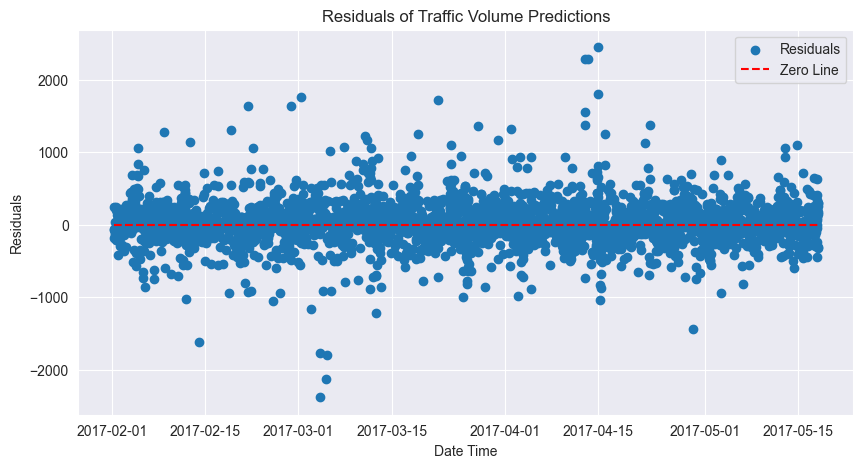

In [7]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test.index, residuals, label='Residuals')
plt.hlines(y=0, xmin=y_test.index.min(), xmax=y_test.index.max(), color='red', linestyles='dashed', label='Zero Line')
plt.title('Residuals of Traffic Volume Predictions')
plt.xlabel('Date Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train on the training set
best_model.fit(X_train, y_train)

# Evaluate on both the training set and validation set
train_predictions = best_model.predict(X_train)
val_predictions = best_model.predict(X_val)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

print(f"Training RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")


Training RMSE: 285.38672214831445
Validation RMSE: 305.40229342010326


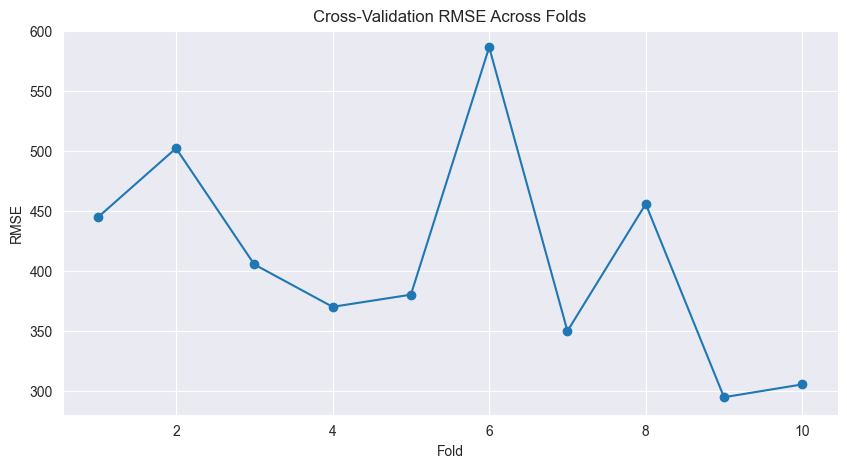

In [9]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(best_model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')

# Convert scores to positive RMSE
rmse_scores = np.sqrt(-scores)

# Plot the scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.title('Cross-Validation RMSE Across Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.show()


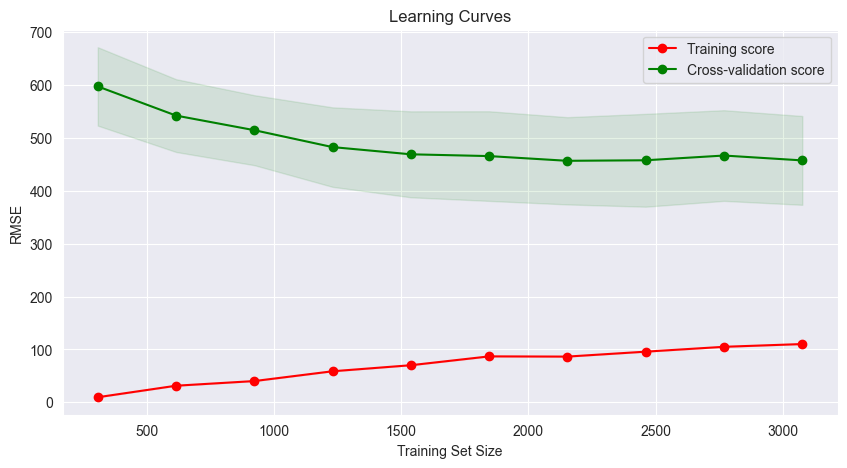

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_scaled, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=tscv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation for train and validation scores
train_mean = np.mean(np.sqrt(-train_scores), axis=1)
train_std = np.std(np.sqrt(-train_scores), axis=1)
val_mean = np.mean(np.sqrt(-val_scores), axis=1)
val_std = np.std(np.sqrt(-val_scores), axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend(loc="best")
plt.show()
